In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/turbofan/df_train.csv
/kaggle/input/turbofan/df_test.csv


In [2]:
def create_sequences(data: pd.DataFrame,target,seq_len):
    sequences = []
    data_size = len(data)

    for i in tqdm(range(data_size-seq_len+1)):
        sequence = data.iloc[i:i+seq_len,:-1]
        label_position = (i+seq_len-1)
        label = data.iloc[label_position][target]

        sequences.append([sequence,label])
    return sequences

In [3]:
!pip install lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 596.7/596.7 kB 40.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 4.7 MB/s eta 0:00:00


In [4]:
import numpy as np
import pandas as pd
from itertools import chain
import os
import warnings
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

#from sklearn.linear_model import LinearRegression as lr
#from sklearn.model_selection import TimeSeriesSplit as tsplit
#from sklearn.model_selection import train_test_split
#from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
#from sklearn.preprocessing import LabelEncoder

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import TensorDataset
import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from lightning.pytorch.loggers import TensorBoardLogger
import torch.optim as optim
from torch.utils.data import Dataset
from collections import defaultdict

In [5]:
df_train = pd.read_csv('/kaggle/input/turbofan/df_train.csv')
df_test = pd.read_csv('/kaggle/input/turbofan/df_test.csv')

In [6]:
#Preparing new data with the columns that will be smoothed
df_train_for_smo = df_train[['unit_abs','sensor2', 'sensor3', 'sensor4', 'sensor7', 'sensor8', 'sensor9',
       'sensor11', 'sensor12', 'sensor13', 'sensor14', 'sensor15', 'sensor17',
       'sensor20', 'sensor21']]
df_test_for_smo = df_test[['unit_abs','sensor2', 'sensor3', 'sensor4', 'sensor7', 'sensor8', 'sensor9',
       'sensor11', 'sensor12', 'sensor13', 'sensor14', 'sensor15', 'sensor17',
       'sensor20', 'sensor21']]

In [7]:
# Smoothing the data with Exponential Weighted Moving Average. It is already implemented in pandas library.
# We need to implement the smoothing over each unit in the dataset, otherwise it would get the noise between the end of the cycle
# of a unit and the beggining of the following unit.

alpha = .2
train_smooth = pd.DataFrame()

for i in range(1, 710):
    unit_data = df_train_for_smo[df_train_for_smo['unit_abs'] == i]  # Extract data for a specific unit
    smoothed_df = unit_data.apply(lambda column: column.ewm(alpha=alpha, adjust=False).mean())
    train_smooth = train_smooth.append(smoothed_df)

In [8]:
# Smoothing the test data with Exponential Weighted Moving Average.
test_smooth = pd.DataFrame()

for i in range(1, 710):
    unit_data = df_test_for_smo[df_test_for_smo['unit_abs'] == i]  # Extract data for a specific unit
    smoothed_df = unit_data.apply(lambda column: column.ewm(alpha=alpha, adjust=False).mean())
    test_smooth = test_smooth.append(smoothed_df)

In [9]:
# Separating the dataset for MinMaxScaler (remove the unit column) #
train_smooth_for_sc = train_smooth.iloc[:,1:]
test_smooth_for_sc = test_smooth.iloc[:,1:]

In [10]:
smooth_col = train_smooth_for_sc.columns

In [11]:
# Standardize the data because neural networks perform better with standardized data. 
scaler = MinMaxScaler()
df_train_sc_np = scaler.fit_transform(train_smooth_for_sc)
df_test_sc_np = scaler.fit_transform(test_smooth_for_sc)

In [12]:
#smooth_col_wr = ['sensor2', 'sensor3', 'sensor4', 'sensor7', 'sensor8', 'sensor9',
       #'sensor11', 'sensor12', 'sensor13', 'sensor14', 'sensor15', 'sensor17',
      # 'sensor20', 'sensor21','RUL']

In [13]:
#df_train_sc_np_wr = scaler.fit_transform(pd.concat([train_smooth_for_sc,df_train['RUL']],axis=1))
#df_test_sc_np_wr = scaler.fit_transform(pd.concat([test_smooth_for_sc,df_test['RUL']],axis=1))
#df_train_sc_wr = pd.DataFrame(df_train_sc_np_wr,columns = smooth_col_wr)
#df_test_sc_wr = pd.DataFrame(df_test_sc_np_wr,columns = smooth_col_wr)


In [14]:
df_train_sc = pd.DataFrame(df_train_sc_np,columns = smooth_col)
df_test_sc = pd.DataFrame(df_test_sc_np,columns = smooth_col)

In [15]:
itrain = pd.concat([df_train_sc,df_train['RUL']],axis=1)
itest = pd.concat([df_test_sc,df_test['RUL']],axis=1)

In [16]:
# Utilize the last 10 units for validation set
idx_val = df_train_sc.iloc[157681:].shape[0]

In [17]:
itrain_rul = itrain.iloc[:-idx_val]
ival_rul = itrain.iloc[-idx_val:].reset_index(drop=True)
itest_rul = itest
ipred_rul  = itest_rul.iloc[53935:].reset_index(drop=True) #For applying the predictor 

In [18]:
#itrain_rul_wr = df_train_sc_wr .iloc[:-idx_val]
#ival_rul_wr = df_train_sc_wr .iloc[-idx_val:].reset_index(drop=True)
#itest_rul_wr = df_test_sc_wr 
#ipred_rul_wr  = df_test_sc_wr .iloc[53935:].reset_index(drop=True) #For applying the predictor 

In [19]:
# Utilizing the RUL as the target
seq_len =10
train_sequences_rul = np.array(create_sequences(itrain_rul,'RUL',seq_len=seq_len))
val_sequences_rul = np.array(create_sequences(ival_rul, 'RUL', seq_len ))
test_sequences_rul = np.array(create_sequences(itest_rul.iloc[:40032],'RUL',seq_len)) #only the first 300 units because of memmory issues
pred_sequences_rul = np.array(create_sequences(ipred_rul,'RUL',seq_len))

  0%|          | 0/157672 [00:00<?, ?it/s]

  0%|          | 0/2669 [00:00<?, ?it/s]

  0%|          | 0/40023 [00:00<?, ?it/s]

  0%|          | 0/50953 [00:00<?, ?it/s]

In [20]:
# Utilizing the RUL as the target
seq_len =80
train_sequences_rul80 = np.array(create_sequences(itrain_rul,'RUL',seq_len=seq_len))
val_sequences_rul80 = np.array(create_sequences(ival_rul, 'RUL', seq_len ))
test_sequences_rul80 = np.array(create_sequences(itest_rul.iloc[:40032],'RUL',seq_len)) #only the first 300 units because of memmory issues
pred_sequences_rul80 = np.array(create_sequences(ipred_rul,'RUL',seq_len))

  0%|          | 0/157602 [00:00<?, ?it/s]

  0%|          | 0/2599 [00:00<?, ?it/s]

  0%|          | 0/39953 [00:00<?, ?it/s]

  0%|          | 0/50883 [00:00<?, ?it/s]

In [21]:
# Utilizing the RUL as the target
seq_len =10
train_sequences_rul3 = np.array(create_sequences(itrain_rul[['sensor2','sensor4','sensor8','RUL']],'RUL',seq_len=seq_len))
val_sequences_rul3 = np.array(create_sequences(ival_rul[['sensor2','sensor4','sensor8','RUL']], 'RUL', seq_len ))
test_sequences_rul3 = np.array(create_sequences(itest_rul[['sensor2','sensor4','sensor8','RUL']].iloc[:40032],'RUL',seq_len)) #only the first 300 units because of memmory issues
pred_sequences_rul3 = np.array(create_sequences(ipred_rul[['sensor2','sensor4','sensor8','RUL']],'RUL',seq_len))

  0%|          | 0/157672 [00:00<?, ?it/s]

  0%|          | 0/2669 [00:00<?, ?it/s]

  0%|          | 0/40023 [00:00<?, ?it/s]

  0%|          | 0/50953 [00:00<?, ?it/s]

In [22]:
#seq_len =10
#train_sequences_rul = np.array(create_sequences(itrain_rul_wr,'RUL',seq_len=seq_len))
#val_sequences_rul = np.array(create_sequences(ival_rul_wr, 'RUL', seq_len ))
#test_sequences_rul = np.array(create_sequences(itest_rul_wr.iloc[:40032],'RUL',seq_len)) #only the first 300 units because of memmory issues
#pred_sequences_rul = np.array(create_sequences(ipred_rul_wr,'RUL',seq_len))

In [23]:
class TurbofanDataset(Dataset):

    def __init__(self,sequences):
        self.sequences = sequences
    def __len__(self):
        return len(self.sequences)
    def __getitem__(self,idx):
        sequence, label = self.sequences[idx]
        return dict(
          sequence=torch.tensor(sequence.to_numpy()).float(),
          label = torch.tensor(label).float()
      )

In [24]:
class TurbofanDataModule(L.LightningDataModule):

    def __init__(self, train_sequences,val_sequences,test_sequences,pred_sequences,batch_size=32):
        super().__init__()
        self.train_sequences = train_sequences
        self.val_sequences = val_sequences
        self.test_sequences = test_sequences
        self.pred_sequences = pred_sequences
        self.batch_size = batch_size

    def setup(self, stage=None):
        self.train_dataset = TurbofanDataset(self.train_sequences)
        self.val_dataset = TurbofanDataset(self.val_sequences)
        self.test_dataset = TurbofanDataset(self.test_sequences)
        self.pred_dataset = TurbofanDataset(self.pred_sequences)

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size = self.batch_size,
            shuffle= False,
            num_workers=1
        )
    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=len(self.val_sequences),
            shuffle = True,
            num_workers=1
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=len(self.test_dataset),
            shuffle = True,
            num_workers=1
        )
    
    def predict_dataloader(self):
        return DataLoader(
            self.pred_dataset,
            batch_size=len(self.pred_dataset),
            #batch_size=1,
            shuffle = False,
            num_workers=1
        )

In [25]:
class RULPredModel(nn.Module):

    def __init__(self, n_features=3, n_hidden=128,n_layers=1):
        super().__init__()
        self.n_features = n_features
        self.n_hidden = n_hidden
        self.n_layers = n_layers

        self.lstm = nn.LSTM(
            input_size = n_features,
            hidden_size = n_hidden,
            batch_first = True,
            num_layers = n_layers,
            
        )

        #self.dropout = nn.Dropout(0.3)
        self.other_layers = nn.Sequential(
            nn.Linear(in_features=self.n_hidden, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=1),
            #nn.ReLU(),
            #nn.Linear(in_features=32, out_features=16),
            #nn.ReLU(),
            #nn.Linear(in_features=16, out_features=1)
        )
        
    def forward(self,x):
        self.lstm.flatten_parameters()
        _, (hidden, _) = self.lstm(x)
        out = hidden[-1]
        #out = self.dropout(out)
        out = self.other_layers(out)

        return out

In [26]:
class RULLightning(L.LightningModule):

    def __init__(self, model=RULPredModel(), lr=0.001):
        super(RULLightning,self).__init__()

        self.lr = lr
        self.model = model

        self.criterion = nn.MSELoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        sequences = batch['sequence']
        labels = batch['label']
        outputs = self(sequences).view(-1)
        loss = self.criterion(outputs, labels)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        sequences = batch['sequence']
        labels = batch['label']
        outputs = self(sequences)
        loss = self.criterion(outputs, labels)
        self.log("val_loss", loss, prog_bar=True, logger=True)
        return loss

    def test_step(self, batch, batch_idx):
        sequences = batch['sequence']
        labels = batch['label']
        outputs = self(sequences)
        loss = self.criterion(outputs, labels)
        self.log("test_loss", loss, prog_bar=True, logger=True)
        return loss
    
    def predict_step(self, 
                     batch, 
                     batch_idx, 
                     dataloader_idx=None
                    ):
        sequences = batch['sequence']
        y_hat = self(sequences)
        return y_hat

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr)
        return optimizer

In [27]:
dm_rul = TurbofanDataModule(train_sequences_rul3,
                            val_sequences_rul3,
                            test_sequences_rul3, 
                            pred_sequences_rul3[:40000]
                           )

In [28]:
logger = TensorBoardLogger(save_dir="/kaggle/working/", name="lightning_logs")

In [29]:
callbacks = [ModelCheckpoint(save_top_k=1,
                             verbose=1,
                             monitor='val_loss',
                             save_last = True,
                             mode='min',
                             filename='best_model',
                             dirpath = logger.log_dir
                            ),
             EarlyStopping(monitor='val_loss',
                           patience=20,
                           mode='min',
                           
                          )
            ]

In [30]:
model = RULLightning(RULPredModel())

In [31]:
trainer = L.Trainer(max_epochs=250,
                    callbacks = callbacks,
                    accelerator='gpu',
                    devices = 1,
                    log_every_n_steps=1,
                    logger=logger,
                    #fast_dev_run=True
                     )
trainer.fit(model=model, datamodule= dm_rul)

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: 
  | Name      | Type         | Params
-------------------------------------------
0 | model     | RULPredModel | 72.3 K
1 | criterion | MSELoss      | 0     
-------------------------------------------
72.3 K    Trainable params
0         Non-trainable params
72.3 K    Total params
0.289     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: Epoch 0, global step 4928: 'val_loss' reached 7291.89502 (best 7291.89502), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 1, global step 9856: 'val_loss' reached 7291.61426 (best 7291.61426), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 2, global step 14784: 'val_loss' reached 7291.39355 (best 7291.39355), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 3, global step 19712: 'val_loss' reached 7291.21777 (best 7291.21777), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 4, global step 24640: 'val_loss' reached 7291.07324 (best 7291.07324), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 5, global step 29568: 'val_loss' reached 7290.95557 (best 7290.95557), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 6, global step 34496: 'val_loss' reached 7290.85889 (best 7290.85889), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 7, global step 39424: 'val_loss' reached 7290.78027 (best 7290.78027), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 8, global step 44352: 'val_loss' reached 7290.71338 (best 7290.71338), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 9, global step 49280: 'val_loss' reached 7290.65771 (best 7290.65771), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 10, global step 54208: 'val_loss' reached 7290.61133 (best 7290.61133), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 11, global step 59136: 'val_loss' reached 7290.57080 (best 7290.57080), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 12, global step 64064: 'val_loss' reached 7290.53809 (best 7290.53809), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 13, global step 68992: 'val_loss' reached 7290.50781 (best 7290.50781), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 14, global step 73920: 'val_loss' reached 7290.48193 (best 7290.48193), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 15, global step 78848: 'val_loss' reached 7290.45850 (best 7290.45850), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 16, global step 83776: 'val_loss' reached 7290.43701 (best 7290.43701), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 17, global step 88704: 'val_loss' reached 7290.41748 (best 7290.41748), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 18, global step 93632: 'val_loss' reached 7290.39844 (best 7290.39844), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 19, global step 98560: 'val_loss' reached 7290.38135 (best 7290.38135), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 20, global step 103488: 'val_loss' reached 7290.36426 (best 7290.36426), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 21, global step 108416: 'val_loss' reached 7290.34863 (best 7290.34863), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 22, global step 113344: 'val_loss' reached 7290.33105 (best 7290.33105), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 23, global step 118272: 'val_loss' reached 7290.31494 (best 7290.31494), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 24, global step 123200: 'val_loss' reached 7290.29883 (best 7290.29883), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 25, global step 128128: 'val_loss' reached 7290.28271 (best 7290.28271), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 26, global step 133056: 'val_loss' reached 7290.26660 (best 7290.26660), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 27, global step 137984: 'val_loss' reached 7290.24951 (best 7290.24951), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 28, global step 142912: 'val_loss' reached 7290.23145 (best 7290.23145), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 29, global step 147840: 'val_loss' reached 7290.21338 (best 7290.21338), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 30, global step 152768: 'val_loss' reached 7290.19580 (best 7290.19580), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 31, global step 157696: 'val_loss' reached 7290.17627 (best 7290.17627), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 32, global step 162624: 'val_loss' reached 7290.15527 (best 7290.15527), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 33, global step 167552: 'val_loss' reached 7290.13330 (best 7290.13330), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 34, global step 172480: 'val_loss' reached 7290.11182 (best 7290.11182), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 35, global step 177408: 'val_loss' reached 7290.08838 (best 7290.08838), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 36, global step 182336: 'val_loss' reached 7290.06299 (best 7290.06299), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 37, global step 187264: 'val_loss' reached 7290.03662 (best 7290.03662), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 38, global step 192192: 'val_loss' reached 7290.00732 (best 7290.00732), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 39, global step 197120: 'val_loss' reached 7289.97803 (best 7289.97803), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 40, global step 202048: 'val_loss' reached 7289.94629 (best 7289.94629), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 41, global step 206976: 'val_loss' reached 7289.91064 (best 7289.91064), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 42, global step 211904: 'val_loss' reached 7289.87500 (best 7289.87500), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 43, global step 216832: 'val_loss' reached 7289.83301 (best 7289.83301), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 44, global step 221760: 'val_loss' reached 7289.79004 (best 7289.79004), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 45, global step 226688: 'val_loss' reached 7289.74219 (best 7289.74219), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 46, global step 231616: 'val_loss' reached 7289.68994 (best 7289.68994), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 47, global step 236544: 'val_loss' reached 7289.62891 (best 7289.62891), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 48, global step 241472: 'val_loss' reached 7289.56396 (best 7289.56396), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 49, global step 246400: 'val_loss' reached 7289.48975 (best 7289.48975), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 50, global step 251328: 'val_loss' reached 7289.40479 (best 7289.40479), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 51, global step 256256: 'val_loss' reached 7289.30762 (best 7289.30762), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 52, global step 261184: 'val_loss' reached 7289.19092 (best 7289.19092), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 53, global step 266112: 'val_loss' reached 7289.04980 (best 7289.04980), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 54, global step 271040: 'val_loss' reached 7288.87305 (best 7288.87305), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 55, global step 275968: 'val_loss' reached 7288.64014 (best 7288.64014), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 56, global step 280896: 'val_loss' reached 7288.30127 (best 7288.30127), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 57, global step 285824: 'val_loss' reached 7287.72412 (best 7287.72412), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 58, global step 290752: 'val_loss' reached 7287.05078 (best 7287.05078), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 59, global step 295680: 'val_loss' reached 7286.93799 (best 7286.93799), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 60, global step 300608: 'val_loss' reached 7286.80420 (best 7286.80420), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 61, global step 305536: 'val_loss' reached 7286.62402 (best 7286.62402), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 62, global step 310464: 'val_loss' reached 7286.36426 (best 7286.36426), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 63, global step 315392: 'val_loss' reached 7285.92432 (best 7285.92432), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 64, global step 320320: 'val_loss' reached 7285.19873 (best 7285.19873), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 65, global step 325248: 'val_loss' reached 7285.15234 (best 7285.15234), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 66, global step 330176: 'val_loss' reached 7285.12842 (best 7285.12842), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 67, global step 335104: 'val_loss' reached 7285.10059 (best 7285.10059), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 68, global step 340032: 'val_loss' reached 7285.07227 (best 7285.07227), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 69, global step 344960: 'val_loss' reached 7285.04102 (best 7285.04102), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 70, global step 349888: 'val_loss' reached 7285.00732 (best 7285.00732), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 71, global step 354816: 'val_loss' reached 7284.96973 (best 7284.96973), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 72, global step 359744: 'val_loss' reached 7284.92822 (best 7284.92822), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 73, global step 364672: 'val_loss' reached 7284.88281 (best 7284.88281), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 74, global step 369600: 'val_loss' reached 7284.83350 (best 7284.83350), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 75, global step 374528: 'val_loss' reached 7284.77539 (best 7284.77539), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 76, global step 379456: 'val_loss' reached 7284.71191 (best 7284.71191), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 77, global step 384384: 'val_loss' reached 7284.63867 (best 7284.63867), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 78, global step 389312: 'val_loss' reached 7284.55371 (best 7284.55371), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 79, global step 394240: 'val_loss' reached 7284.45508 (best 7284.45508), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 80, global step 399168: 'val_loss' reached 7284.33740 (best 7284.33740), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 81, global step 404096: 'val_loss' reached 7284.19482 (best 7284.19482), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 82, global step 409024: 'val_loss' reached 7284.01660 (best 7284.01660), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 83, global step 413952: 'val_loss' reached 7283.78271 (best 7283.78271), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 84, global step 418880: 'val_loss' reached 7283.45654 (best 7283.45654), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 85, global step 423808: 'val_loss' reached 7282.94629 (best 7282.94629), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 86, global step 428736: 'val_loss' reached 7282.07471 (best 7282.07471), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 87, global step 433664: 'val_loss' reached 7281.74658 (best 7281.74658), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 88, global step 438592: 'val_loss' reached 7281.24561 (best 7281.24561), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 89, global step 443520: 'val_loss' reached 7280.76660 (best 7280.76660), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 90, global step 448448: 'val_loss' reached 7280.76416 (best 7280.76416), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 91, global step 453376: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 92, global step 458304: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 93, global step 463232: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 94, global step 468160: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 95, global step 473088: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 96, global step 478016: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 97, global step 482944: 'val_loss' reached 7280.76367 (best 7280.76367), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 98, global step 487872: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 99, global step 492800: 'val_loss' reached 7280.76270 (best 7280.76270), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 100, global step 497728: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 101, global step 502656: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 102, global step 507584: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 103, global step 512512: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 104, global step 517440: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 105, global step 522368: 'val_loss' reached 7280.76221 (best 7280.76221), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 106, global step 527296: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 107, global step 532224: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 108, global step 537152: 'val_loss' reached 7280.76074 (best 7280.76074), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 109, global step 542080: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 110, global step 547008: 'val_loss' reached 7280.75977 (best 7280.75977), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 111, global step 551936: 'val_loss' reached 7280.75781 (best 7280.75781), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 112, global step 556864: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 113, global step 561792: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 114, global step 566720: 'val_loss' reached 7280.75586 (best 7280.75586), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 115, global step 571648: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 116, global step 576576: 'val_loss' reached 7280.75537 (best 7280.75537), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 117, global step 581504: 'val_loss' reached 7280.75391 (best 7280.75391), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 118, global step 586432: 'val_loss' reached 7280.75293 (best 7280.75293), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 119, global step 591360: 'val_loss' reached 7280.75146 (best 7280.75146), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 120, global step 596288: 'val_loss' reached 7280.75098 (best 7280.75098), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 121, global step 601216: 'val_loss' reached 7280.75000 (best 7280.75000), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 122, global step 606144: 'val_loss' reached 7280.74951 (best 7280.74951), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 123, global step 611072: 'val_loss' reached 7280.74707 (best 7280.74707), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 124, global step 616000: 'val_loss' reached 7280.74658 (best 7280.74658), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 125, global step 620928: 'val_loss' reached 7280.74463 (best 7280.74463), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 126, global step 625856: 'val_loss' reached 7280.72070 (best 7280.72070), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 127, global step 630784: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 128, global step 635712: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 129, global step 640640: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 130, global step 645568: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 131, global step 650496: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 132, global step 655424: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 133, global step 660352: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 134, global step 665280: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 135, global step 670208: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 136, global step 675136: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 137, global step 680064: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 138, global step 684992: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 139, global step 689920: 'val_loss' reached 7280.71875 (best 7280.71875), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 140, global step 694848: 'val_loss' reached 7280.71729 (best 7280.71729), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 141, global step 699776: 'val_loss' reached 7280.71338 (best 7280.71338), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 142, global step 704704: 'val_loss' reached 7280.71045 (best 7280.71045), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 143, global step 709632: 'val_loss' reached 7280.70801 (best 7280.70801), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 144, global step 714560: 'val_loss' reached 7280.70605 (best 7280.70605), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 145, global step 719488: 'val_loss' reached 7280.70215 (best 7280.70215), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 146, global step 724416: 'val_loss' reached 7280.69824 (best 7280.69824), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 147, global step 729344: 'val_loss' reached 7280.69531 (best 7280.69531), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 148, global step 734272: 'val_loss' reached 7280.69141 (best 7280.69141), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 149, global step 739200: 'val_loss' reached 7280.68848 (best 7280.68848), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 150, global step 744128: 'val_loss' reached 7280.68506 (best 7280.68506), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 151, global step 749056: 'val_loss' reached 7280.68213 (best 7280.68213), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 152, global step 753984: 'val_loss' reached 7280.67725 (best 7280.67725), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 153, global step 758912: 'val_loss' reached 7280.67383 (best 7280.67383), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 154, global step 763840: 'val_loss' reached 7280.66895 (best 7280.66895), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 155, global step 768768: 'val_loss' reached 7280.66406 (best 7280.66406), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 156, global step 773696: 'val_loss' reached 7280.65918 (best 7280.65918), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 157, global step 778624: 'val_loss' reached 7280.65430 (best 7280.65430), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 158, global step 783552: 'val_loss' reached 7280.64990 (best 7280.64990), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 159, global step 788480: 'val_loss' reached 7280.64355 (best 7280.64355), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 160, global step 793408: 'val_loss' reached 7280.63916 (best 7280.63916), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 161, global step 798336: 'val_loss' reached 7280.63232 (best 7280.63232), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 162, global step 803264: 'val_loss' reached 7280.62646 (best 7280.62646), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 163, global step 808192: 'val_loss' reached 7280.61963 (best 7280.61963), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 164, global step 813120: 'val_loss' reached 7280.61279 (best 7280.61279), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 165, global step 818048: 'val_loss' reached 7280.60449 (best 7280.60449), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 166, global step 822976: 'val_loss' reached 7280.59814 (best 7280.59814), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 167, global step 827904: 'val_loss' reached 7280.59033 (best 7280.59033), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 168, global step 832832: 'val_loss' reached 7280.58154 (best 7280.58154), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 169, global step 837760: 'val_loss' reached 7280.57227 (best 7280.57227), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 170, global step 842688: 'val_loss' reached 7280.56299 (best 7280.56299), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 171, global step 847616: 'val_loss' reached 7280.55176 (best 7280.55176), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 172, global step 852544: 'val_loss' reached 7280.54248 (best 7280.54248), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 173, global step 857472: 'val_loss' reached 7280.52979 (best 7280.52979), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 174, global step 862400: 'val_loss' reached 7280.51709 (best 7280.51709), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 175, global step 867328: 'val_loss' reached 7280.50342 (best 7280.50342), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 176, global step 872256: 'val_loss' reached 7280.49023 (best 7280.49023), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 177, global step 877184: 'val_loss' reached 7280.47412 (best 7280.47412), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 178, global step 882112: 'val_loss' reached 7280.45850 (best 7280.45850), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 179, global step 887040: 'val_loss' reached 7280.43896 (best 7280.43896), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 180, global step 891968: 'val_loss' reached 7280.41943 (best 7280.41943), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 181, global step 896896: 'val_loss' reached 7280.37744 (best 7280.37744), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 182, global step 901824: 'val_loss' reached 7280.37451 (best 7280.37451), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 183, global step 906752: 'val_loss' reached 7280.34717 (best 7280.34717), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 184, global step 911680: 'val_loss' reached 7280.31641 (best 7280.31641), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 185, global step 916608: 'val_loss' reached 7280.28320 (best 7280.28320), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 186, global step 921536: 'val_loss' reached 7280.24561 (best 7280.24561), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 187, global step 926464: 'val_loss' reached 7280.20068 (best 7280.20068), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 188, global step 931392: 'val_loss' reached 7280.15039 (best 7280.15039), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 189, global step 936320: 'val_loss' reached 7280.09082 (best 7280.09082), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 190, global step 941248: 'val_loss' reached 7280.01709 (best 7280.01709), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 191, global step 946176: 'val_loss' reached 7279.92725 (best 7279.92725), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 192, global step 951104: 'val_loss' reached 7279.81104 (best 7279.81104), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 193, global step 956032: 'val_loss' reached 7279.65527 (best 7279.65527), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 194, global step 960960: 'val_loss' reached 7279.42578 (best 7279.42578), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 195, global step 965888: 'val_loss' reached 7279.03809 (best 7279.03809), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 196, global step 970816: 'val_loss' reached 7278.38867 (best 7278.38867), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 197, global step 975744: 'val_loss' reached 7278.36182 (best 7278.36182), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 198, global step 980672: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 199, global step 985600: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 200, global step 990528: 'val_loss' reached 7278.36133 (best 7278.36133), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 201, global step 995456: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 202, global step 1000384: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 203, global step 1005312: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 204, global step 1010240: 'val_loss' reached 7278.35986 (best 7278.35986), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 205, global step 1015168: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 206, global step 1020096: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 207, global step 1025024: 'val_loss' reached 7278.35840 (best 7278.35840), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 208, global step 1029952: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 209, global step 1034880: 'val_loss' reached 7278.35742 (best 7278.35742), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 210, global step 1039808: 'val_loss' reached 7278.35645 (best 7278.35645), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 211, global step 1044736: 'val_loss' reached 7278.35498 (best 7278.35498), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 212, global step 1049664: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 213, global step 1054592: 'val_loss' reached 7278.35352 (best 7278.35352), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 214, global step 1059520: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 215, global step 1064448: 'val_loss' reached 7278.35303 (best 7278.35303), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 216, global step 1069376: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 217, global step 1074304: 'val_loss' reached 7278.35156 (best 7278.35156), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 218, global step 1079232: 'val_loss' reached 7278.35059 (best 7278.35059), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 219, global step 1084160: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 220, global step 1089088: 'val_loss' reached 7278.35010 (best 7278.35010), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 221, global step 1094016: 'val_loss' reached 7278.34863 (best 7278.34863), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 222, global step 1098944: 'val_loss' reached 7278.34766 (best 7278.34766), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 223, global step 1103872: 'val_loss' reached 7278.34521 (best 7278.34521), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 224, global step 1108800: 'val_loss' reached 7278.34473 (best 7278.34473), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 225, global step 1113728: 'val_loss' reached 7278.34375 (best 7278.34375), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 226, global step 1118656: 'val_loss' reached 7278.34229 (best 7278.34229), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 227, global step 1123584: 'val_loss' reached 7278.31787 (best 7278.31787), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 228, global step 1128512: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 229, global step 1133440: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 230, global step 1138368: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 231, global step 1143296: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 232, global step 1148224: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 233, global step 1153152: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 234, global step 1158080: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 235, global step 1163008: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 236, global step 1167936: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 237, global step 1172864: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 238, global step 1177792: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 239, global step 1182720: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 240, global step 1187648: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 241, global step 1192576: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 242, global step 1197504: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 243, global step 1202432: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 244, global step 1207360: 'val_loss' reached 7278.31641 (best 7278.31641), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 245, global step 1212288: 'val_loss' reached 7278.31494 (best 7278.31494), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 246, global step 1217216: 'val_loss' reached 7278.31152 (best 7278.31152), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 247, global step 1222144: 'val_loss' reached 7278.30957 (best 7278.30957), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 248, global step 1227072: 'val_loss' reached 7278.30811 (best 7278.30811), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 249, global step 1232000: 'val_loss' reached 7278.30566 (best 7278.30566), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1
INFO: `Trainer.fit` stopped: `max_epochs=250` reached.


In [32]:
!ls /kaggle/working/lightning_logs/

version_0


In [33]:
check_path = "/kaggle/working/lightning_logs/version_0/best_model.ckpt"

In [34]:
test = trainer.test(datamodule=dm_rul, ckpt_path=check_path)

INFO: Restoring states from the checkpoint path at /kaggle/working/lightning_logs/version_0/best_model.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: Loaded model weights from the checkpoint at /kaggle/working/lightning_logs/version_0/best_model.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     4279.68408203125      │
└───────────────────────────┴───────────────────────────┘

In [35]:
pred = trainer.predict(datamodule=dm_rul, ckpt_path=check_path)

INFO: Restoring states from the checkpoint path at /kaggle/working/lightning_logs/version_0/best_model.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: Loaded model weights from the checkpoint at /kaggle/working/lightning_logs/version_0/best_model.ckpt


Predicting: 0it [00:00, ?it/s]

In [36]:
pred_np = pred[0].numpy()
predicted = pd.Series(pred_np.T[0],name ='Pred')

In [37]:
predicted.std()

0.0

In [38]:
true_y = pd.Series(pred_sequences_rul[:,1])

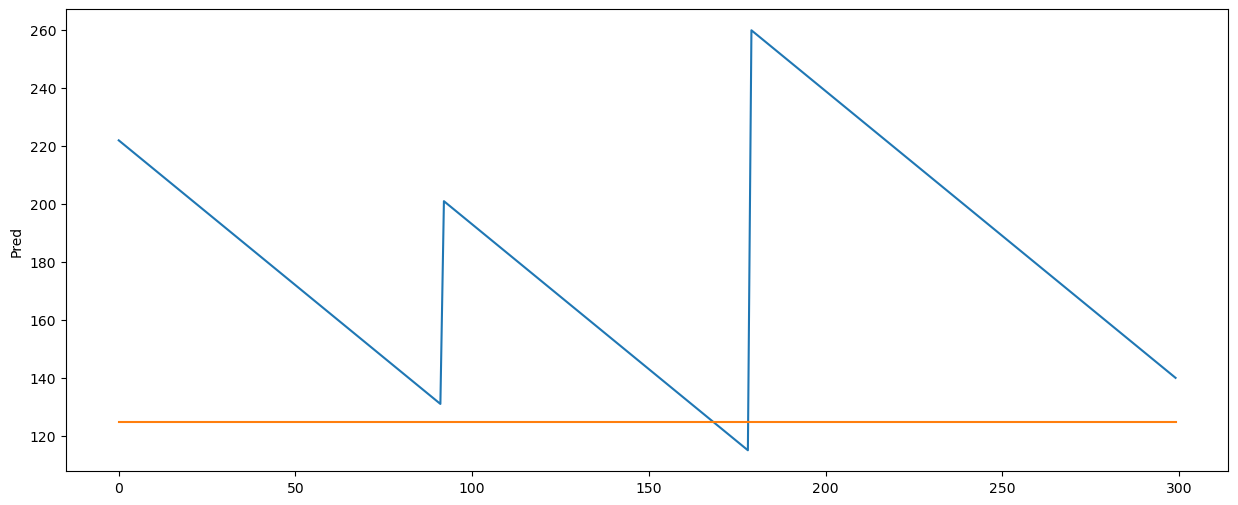

In [39]:
ini = 0
final = 300
plt.figure(figsize=(15, 6))
sns.lineplot(true_y.iloc[ini:final])
sns.lineplot(predicted.iloc[ini:final])
plt.show()

In [40]:
df_train_drop10 = itrain.iloc[:0]
for i in range(1,699):
    drop10 = itrain[itrain['unit_abs']==i][10:]
    df_train_drop10.append(drop10)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /opt/conda/lib/python3.10/site-packages/pandas/core/indexes/base.py:3802 in get_loc              │
│                                                                                                  │
│   3799 │   │   │   │   )                                                                         │
│   3800 │   │   │   casted_key = self._maybe_cast_indexer(key)                                    │
│   3801 │   │   │   try:                                                                          │
│ ❱ 3802 │   │   │   │   return self._engine.get_loc(casted_key)                                   │
│   3803 │   │   │   except KeyError as err:                                                       │
│   3804 │   │   │   │   raise KeyError(key) from err                                              │
│   3805 │   │   │   except TypeError:                                                             │
│                                                                                                  │
│ in pandas._libs.index.IndexEngine.get_loc:138                                                    │
│                                                                                                  │
│ in pandas._libs.index.IndexEngine.get_loc:165                                                    │
│                                                                                                  │
│ in pandas._libs.hashtable.PyObjectHashTable.get_item:5745                                        │
│                                                                                                  │
│ in pandas._libs.hashtable.PyObjectHashTable.get_item:5753                                        │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyError: 'unit_abs'

The above exception was the direct cause of the following exception:

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:3                                                                                    │
│                                                                                                  │
│   1 df_train_drop10 = itrain.iloc[:0]                                                            │
│   2 for i in range(1,699):                                                                       │
│ ❱ 3 │   drop10 = itrain[itrain['unit_abs']==i][10:]                                              │
│   4 │   df_train_drop10.append(drop10)                                                           │
│   5                                                                                              │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/pandas/core/frame.py:3807 in __getitem__                 │
│                                                                                                  │
│    3804 │   │   if is_single_key:                                                                │
│    3805 │   │   │   if self.columns.nlevels > 1:                                                 │
│    3806 │   │   │   │   return self._getitem_multilevel(key)                                     │
│ ❱  3807 │   │   │   indexer = self.columns.get_loc(key)                                          │
│    3808 │   │   │   if is_integer(indexer):                                                      │
│    3809 │   │   │   │   indexer = [indexer]                                                      │
│    3810 │   │   else:                                                                            │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/pandas/core/indexes/base.py:

In [ ]:
df_test_drop10 = itrain.iloc[:0]
for i in range(1,699):
    drop10 = itrain[itrain['unit_abs']==i][10:]
    df_train_drop10.append(drop10)